In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!pip install tensorflow==2.12.0
# !pip install -U keras
!pip install keras==2.12.0rc1 --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires keras<2.13,>=2.12.0, but you have keras 2.12.0rc1 which is incompatible.


In [3]:
!kaggle datasets download -d prasunroy/natural-images

 97% 332M/342M [00:04<00:00, 105MB/s]
100% 342M/342M [00:04<00:00, 83.3MB/s]


In [6]:
!unzip /content/natural-images.zip

Archive:  /content/natural-images.zip
replace data/natural_images/airplane/airplane_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
### Imports #
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from tensorflow.keras.layers import Input,GaussianNoise, Conv2DTranspose,Conv2D, MaxPooling2D, Flatten, Dense, Reshape, concatenate,BatchNormalization
from keras import backend
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

%matplotlib inline

In [2]:
from keras.models import load_model
from tensorflow.keras.utils  import get_custom_objects



In [3]:
# DATA_DIR = "./imagenet"
# TRAIN_DIR = os.path.join(DATA_DIR, "train")
# for c in os.listdir(TRAIN_DIR):
#         c_dir = os.path.join(TRAIN_DIR, c)
#         print(c_dir)

In [4]:
### Constants ###
DATA_DIR = "./data/"
TRAIN_DIR = os.path.join(DATA_DIR, "natural_images")
IMG_SHAPE = (128, 128)

def load_dataset_small(num_images_per_class_train=700, num_images_test=500):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """
   #./data/natural_images
   #/content/data/natural_images/airplane
    X_train = []
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c)
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            img_i = tf.image.resize(img_i,IMG_SHAPE)

            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    return np.array(X_train)


In [5]:
X_train = load_dataset_small()

# Normalize image vectors.


# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 128, 128, 3).

Number of training examples = 5600
X_train shape: (5600, 128, 128, 3)


In [6]:
# We split training set into two halfs.
# First half is used for training as secret images, second half for cover images.


input_C = X_train[0:X_train.shape[0] // 2]/255.0
# C: cover image
# S1: secret image1
input_S1= X_train[X_train.shape[0] // 2:]/255.0
# input_S1.resize(X_train.shape[0] // 2,64,64,3)
del(X_train)

In [7]:
np.max(input_C),np.max(input_S1)

(1.0, 1.0)

In [8]:
input_S1.dtype,input_C.dtype

(dtype('float32'), dtype('float32'))

In [9]:
input_C.shape[0]

2800

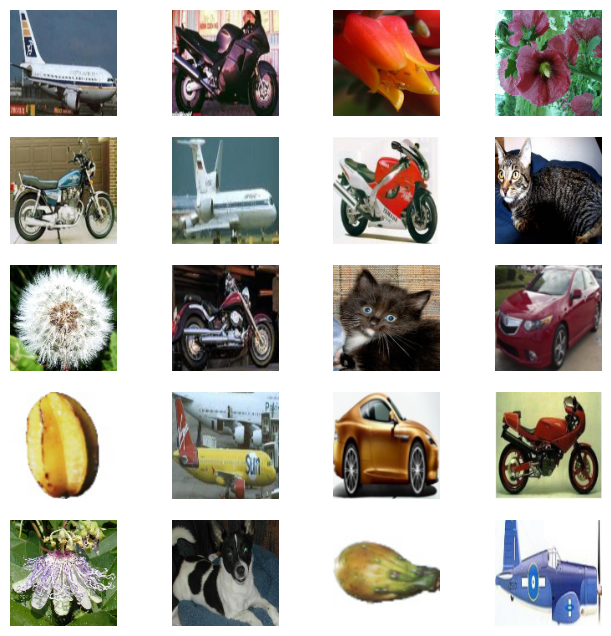

In [10]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(input_C.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.axis(False)
    plt.imshow(input_C[img_idx])
plt.show()

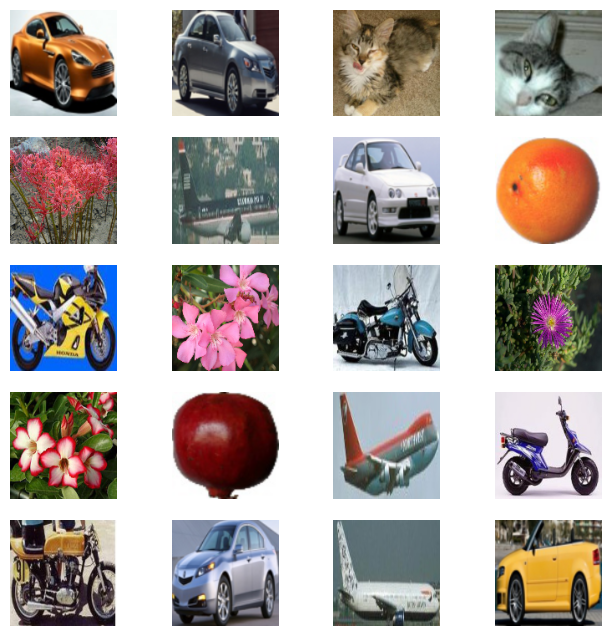

In [11]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(input_S1.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.axis(False)
    plt.imshow(input_S1[img_idx])
plt.show()

In [12]:
input_S1.shape[-3:]

(128, 128, 3)

#MODELS



In [13]:
#Variable used to weight the losses of the secret and cover images.
beta = 0.9
INPUT_SHAPE=input_S1.shape[-3:]
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    #return s_true-s_pred

    print('Calc Loss for reveal network....')
    return beta * K.sum(K.square(s_true - s_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    print('Calc Loss for the full EncoderDecoder model.....')
    s1_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s1_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]

    #s_loss = rev_loss(s_true, s_pred)
    s1_loss = beta * K.sum(K.square(s1_true - s1_pred))
    c_loss = K.sum(K.square(c_true - c_pred))

    return s1_loss + c_loss



In [14]:

# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):

    input_S1 = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3_1')(input_S1)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4_1')(input_S1)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5_1')(input_S1)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4_1')(input_S1)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5_1')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3_2')(input_S1)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5_2')(x)
    x1 = concatenate([x3, x4, x5])

    x = concatenate([input_C, x1])

    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(input_C)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])

    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)

    return Model(inputs=[input_S1, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')



In [15]:
# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):

    # Reveal network
    reveal_input = Input(shape=(input_size))

    # Adding Gaussian noise with 0.01 standard deviation.
    # input_with_noise = GaussianNoise(0.01, name='output_C_noise1')(reveal_input)

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3_1')(reveal_input)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4_1')(reveal_input)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5_1')(reveal_input)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3_1')(reveal_input)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5_1')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5_1')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5_1')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_5x5_1')(x)
    x = concatenate([x3, x4, x5])

    output_S1prime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S1')(x)

    return Model(inputs=reveal_input,
                     outputs=output_S1prime)



In [16]:
## make discrimnator
def discriminator_network(input_shape):
    input_image = Input(shape=input_shape)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_image)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Flatten the output and add a dense layer to output the binary classification
    x = Flatten()(x)
    classification = Dense(1, activation='sigmoid')(x)

    return Model(inputs=input_image, outputs=classification)

In [17]:
def make_encoderDecoderNetwork(input_size):

    input_S1 = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    encoder = make_encoder(input_size)

    decoder1 = make_decoder(input_size)
    decoder1.compile(optimizer='adam', loss=rev_loss)
    decoder1.trainable = False

    output_Cprime = encoder([input_S1,  input_C])
    output_S1prime = decoder1(output_Cprime)

    encoderDecoderNetwork = Model(inputs=[input_S1, input_C],
                        outputs=concatenate([output_S1prime, output_Cprime]))
    encoderDecoderNetwork.compile(optimizer='adam', loss=full_loss)

    return encoder, decoder1, encoderDecoderNetwork

In [18]:
encoder_model, reveal_model,encoderDecoderNetwork = make_encoderDecoderNetwork(INPUT_SHAPE)
discriminator=discriminator_network(INPUT_SHAPE)
discriminator.compile(optimizer='adam', loss='binary_crossentropy')
discriminator.trainable=False

In [19]:
encoder_model.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_prep0_3x3_1 (Conv2D)      (None, 128, 128, 50  1400        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv_prep0_4x4_1 (Conv2D)      (None, 128, 128, 10  490         ['input_3[0][0]']                
                                )                                                           

In [20]:
reveal_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_rev0_3x3_1 (Conv2D)       (None, 128, 128, 50  1400        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv_rev0_4x4_1 (Conv2D)       (None, 128, 128, 10  490         ['input_5[0][0]']                
                                )                                                             

In [21]:
def lr_schedule(epoch_idx):
    if epoch_idx <40:
        return 0.001
    elif epoch_idx < 80:
        return 0.0003
    else:
        return 0.0001

NB_EPOCHS = 100
BATCH_SIZE = 64

m = input_S1.shape[0]
loss_history = []

In [22]:

#loss_history2 = []
for epoch in range(NB_EPOCHS):

    np.random.shuffle(input_S1)
    np.random.shuffle(input_C)

    t = tqdm(range(0, input_S1.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss1 = []
    disc_loss = []

    for idx in t:

        batch_S1 = input_S1[idx:min(idx + BATCH_SIZE, m)]

        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]

        C_prime = encoder_model.predict([batch_S1, batch_C])

        # Discriminate between the steganographic image and the cover image

        realDicLoss=discriminator.train_on_batch(x= batch_C,
                                                      y=tf.ones(shape=(C_prime.shape[0],1) ) )
        fakeDicLoss=discriminator.train_on_batch(x= batch_S1,
                                                      y=tf.zeros(shape=(C_prime.shape[0],1)) )
        disc_loss.append(realDicLoss+fakeDicLoss)

        ae_loss.append(encoderDecoderNetwork.train_on_batch(x=[batch_S1, batch_C],
                                                      y=np.concatenate((batch_S1, batch_C),axis=3)))

        rev_loss1.append(reveal_model.train_on_batch(x=C_prime,
                                              y=batch_S1))

        # Update learning rate
        K.set_value(encoderDecoderNetwork.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))


        t.set_description('Epoch {} | Batch: {:3} of {}. Loss EncoderDecoder {:10.2f} | Loss Decoder {:10.2f},  Loss Discrminator {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss1),np.mean(disc_loss)))

    # encoderDecoderNetwork.save_weights('models/model3_'+str(epoch))
    #autoencoder_model2.save_weights('models/model'+str(epoch))

    loss_history.append(np.mean(ae_loss))
    #loss_history2.append(np.mean(ae_loss2))

  0%|          | 0/44 [00:10<?, ?it/s]


KeyboardInterrupt: ignored

#Save models


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
get_custom_objects().update({'full_loss': full_loss})
get_custom_objects().update({'rev_loss': rev_loss})


In [22]:
encoderDecoderNetwork.save('/content/drive/MyDrive/encoderDecoderNetwork.h5')
encoder_model.save('/content/drive/MyDrive/encoder_model.h5')
reveal_model.save('/content/drive/MyDrive/reveal_model.h5')

#Load models

In [25]:
encoderDecoderNetwork = load_model("/content/drive/MyDrive/encoderDecoderNetwork.h5")
encoder_model=load_model('/content/drive/MyDrive/encoder_model.h5')
reveal_model=load_model('/content/drive/MyDrive/reveal_model.h5')

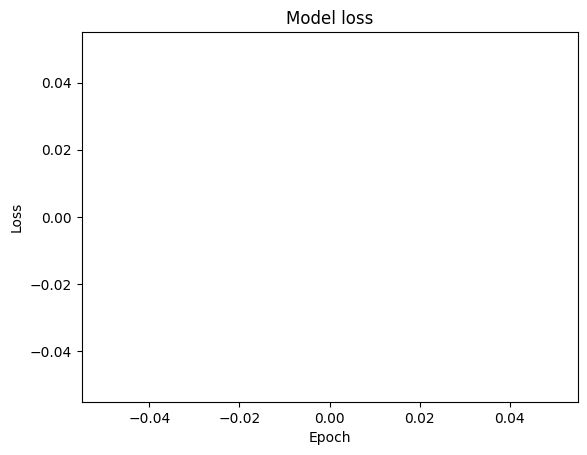

In [26]:
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [27]:
def pixel_errors(input_S1,input_C, decoded_S1, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_S1pixel = np.sqrt(np.mean(np.square(255*(input_S1 - decoded_S1))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))

    return see_S1pixel, see_Cpixel


In [28]:
model=encoderDecoderNetwork

In [29]:
# Retrieve decoded predictions.
decoded = encoderDecoderNetwork.predict([input_S1, input_C])
decoded_S1, decoded_C = decoded[...,0:3], decoded[...,3:6]

88/88 [==============================] - 17s 187ms/step


In [30]:
decoded.shape

(2800, 128, 128, 6)

In [31]:
# Print pixel-wise average errors in a 256 scale.
S1_error, C_error = pixel_errors(input_S1, input_C, decoded_S1, decoded_C)
print ("S1 error per pixel [0, 255]:", S1_error)
print ("C error per pixel [0, 255]:", C_error)

S1 error per pixel [0, 255]: 17.781225
C error per pixel [0, 255]: 16.50262


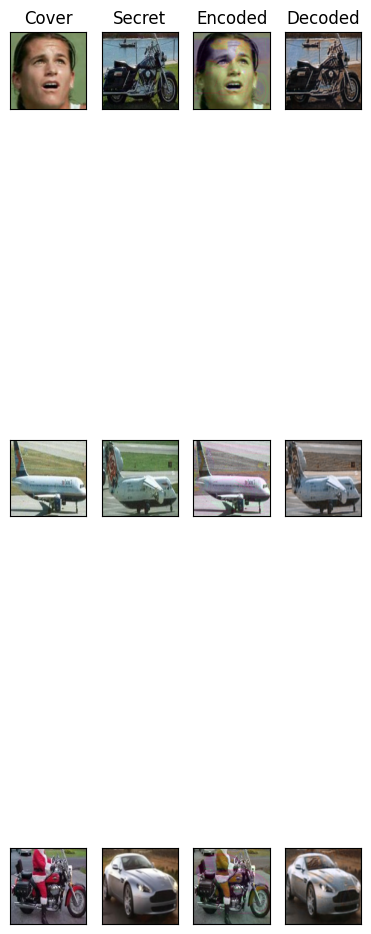

In [32]:
# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 3

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 500) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 12 if SHOW_DIFF else 8

    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S1[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')

    show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded')

    show_image(decoded_S1[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded')

    # if SHOW_DIFF:
    #     show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 9, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')

    #     show_image(np.multiply(diff_S1[idx], ENHANCE), n, n_col, i * n_col + 10, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret1')


plt.show()

#encoder model

(-0.5, 127.5, 127.5, -0.5)

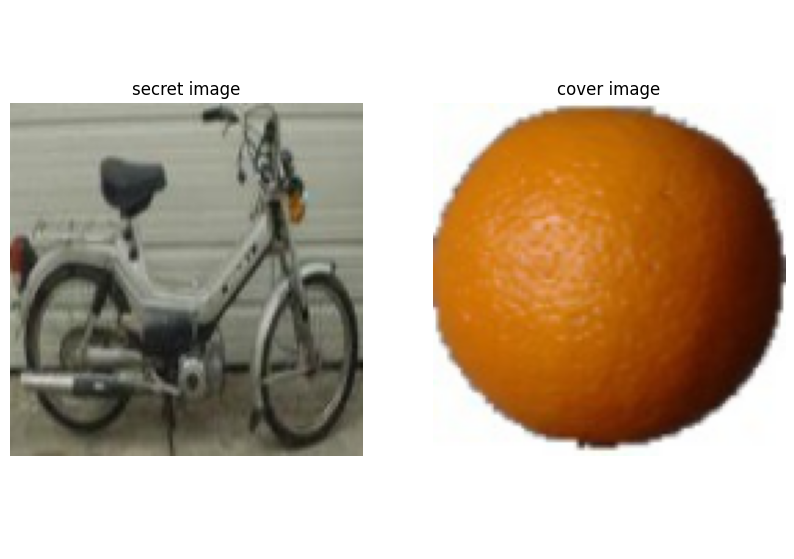

In [55]:
fig = plt.figure(figsize=(10, 7))
plt.axis('off')
ax = fig.add_subplot(1, 2, 1)
plt.title('secret image')

ax.imshow(input_S1[1])
ax.axis('off')
ax = fig.add_subplot(1, 2, 2)
plt.title('cover image')

ax.imshow(input_C[0])
ax.axis('off')

In [59]:
encoded=encoder_model.predict([np.expand_dims(input_S1[1],axis=0),np.expand_dims(input_C[0],axis=0)])

1/1 [==============================] - 0s 35ms/step


In [60]:
encoded.shape

(1, 128, 128, 3)

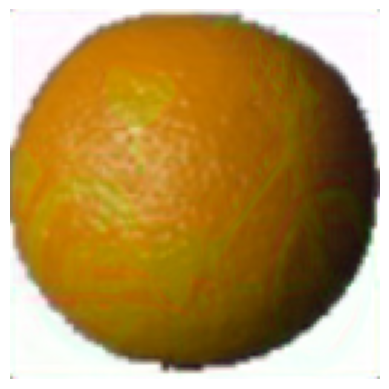

In [61]:
plt.axis(False)
plt.imshow(encoded[0])

#reveal model

load encoded image

In [62]:
path='/content/download (4).png'
img_i = image.load_img(path)
img_i = tf.image.resize(img_i,IMG_SHAPE)/255

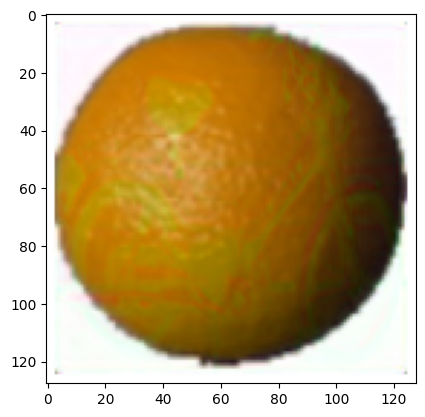

In [63]:
plt.imshow(img_i)

In [64]:
decoded_img=reveal_model.predict(np.expand_dims(img_i,axis=0))

1/1 [==============================] - 0s 157ms/step


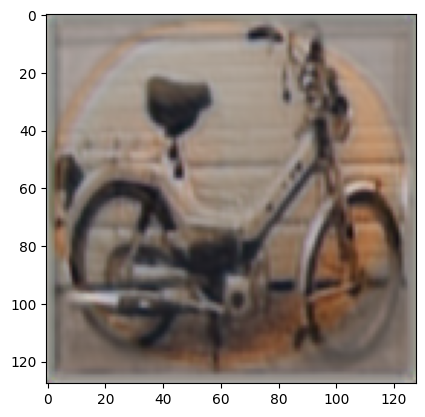

In [65]:
plt.imshow(decoded_img[0])

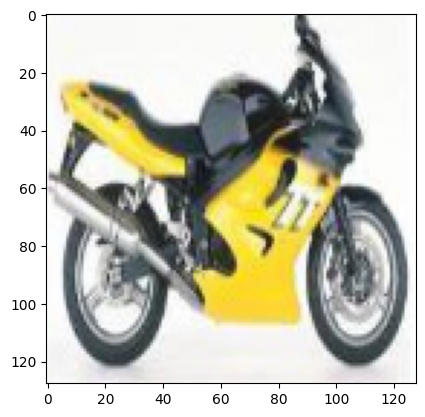

In [76]:
plt.imshow(input_S1[2])
plt.imsave("input_S.png",input_S1[2])

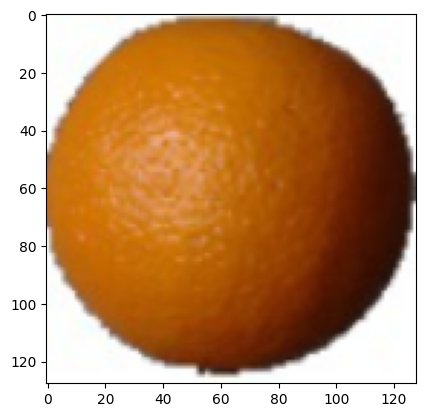

In [67]:
plt.imshow(input_C[0])
plt.imsave("input_C.png",input_C[0])

# View Model and make Prediction


In [69]:
import tensorflow.experimental.numpy as tnp
tnp.experimental_enable_numpy_behavior()


In [70]:
!pip install gradio
import gradio as gr


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 4.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. 

In [71]:
size=IMG_SHAPE[0]

In [72]:
def transcribe(input_SS,input_CC):
    # print(np.amax(input_CC))

    input_CC = input_CC/255
    input_CC=input_CC.astype(np.float32)

    input_SS= input_SS/255
    input_SS= input_SS.astype(np.float32)

    decoded = model.predict([np.expand_dims(input_SS,axis=0), np.expand_dims(input_CC,axis=0)])
    decoded_S1, decoded_C = decoded[...,0:3], decoded[...,3:6]
    decoded=np.clip(decoded_S1[0],0.0,1.0).reshape(size, size,3)
    decoded_C= np.clip(decoded_C[0],0.0,1.0).reshape(size, size,3)


    return  decoded,decoded_C

In [77]:

gr.Interface(
    fn=transcribe,

    inputs=[gr.Image.style(height=size,width=size,self=gr.Image( label="Cover Image")),
    gr.Image.style(height=size,width=size,self=gr.Image( label="Secret Image"))],
    outputs=[gr.Image.style(height=size,width=size,self=gr.Image(label="Compined")),
             gr.Image.style(height=size,width=size,self=gr.Image(label="Decoded"))],
    examples=[["input_C.png", "input_S.png"]]).launch(share=True)

<ipython-input-77-0359c7dc82df>:4: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  inputs=[gr.Image.style(height=size,width=size,self=gr.Image( label="Cover Image")),
<ipython-input-77-0359c7dc82df>:5: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  gr.Image.style(height=size,width=size,self=gr.Image( label="Secret Image"))],
<ipython-input-77-0359c7dc82df>:6: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  outputs=[gr.Image.style(height=size,width=size,self=gr.Image(label="Compined")),
<ipython-input-77-0359c7dc82df>:7: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  gr.Image.style(height=size,width=size,self=gr.Image(label="Decoded"))],


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://1b2d5f6fca1a8d9ddf.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# Encoder Gradio

In [80]:
def Encoder_function(input_SS,input_CC):
    # print(np.amax(input_CC))
    input_SS = tf.image.resize(input_SS,IMG_SHAPE)
    input_CC = tf.image.resize(input_CC,IMG_SHAPE)

    input_CC = input_CC/255
    input_CC=input_CC.astype(np.float32)

    input_SS= input_SS/255
    input_SS= input_SS.astype(np.float32)

    encoded = encoder_model.predict([np.expand_dims(input_CC,axis=0), np.expand_dims(input_SS,axis=0)])
    encoded= np.clip(encoded[0],0.0,1.0).reshape(size, size,3)
    plt.imsave("encoded.png",encoded)

    return  encoded

In [81]:
size=IMG_SHAPE[0]
gr.Interface(
    fn=Encoder_function,

    inputs=[gr.Image.style(height=size,width=size,self=gr.Image( label="Cover Image")),
    gr.Image.style(height=size,width=size,self=gr.Image( label="Secret Image"))],
    outputs=[gr.Image.style(height=size,width=size,self=gr.Image(label="Encoded Img"))],
    examples=[["input_C.png", "input_S.png"]]).launch(share=True)

<ipython-input-81-d08c831705dd>:5: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  inputs=[gr.Image.style(height=size,width=size,self=gr.Image( label="Cover Image")),
<ipython-input-81-d08c831705dd>:6: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  gr.Image.style(height=size,width=size,self=gr.Image( label="Secret Image"))],
<ipython-input-81-d08c831705dd>:7: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  outputs=[gr.Image.style(height=size,width=size,self=gr.Image(label="Encoded Img"))],


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://18c1c02b9751d43751.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


#Decoded Gradio

In [82]:
def Decoder_function(input_SS):
    # print(np.amax(input_CC))

    input_SS= input_SS/255
    input_SS= input_SS.astype(np.float32)

    decoded_img=reveal_model.predict(np.expand_dims(input_SS,axis=0))
    decoded= np.clip(decoded_img[0],0.0,1.0).reshape(size, size,3)


    return  decoded

In [ ]:
size=IMG_SHAPE[0]
gr.Interface(
    fn=Decoder_function,

    inputs=[gr.Image.style(height=size,width=size,self=gr.Image( label="encoded Image"))],
    outputs=[gr.Image.style(height=size,width=size,self=gr.Image(label="decoded Img"))],
    examples=["encoded.png"]).launch(share=True)